# Import dependencies
First, you may need to install 
* NumPy - `pip install numpy`,
* Matplotlib - `pip install matplotlib`,
* PyTorch - `pip install torch torchvision`.

Second, you need to change the current directory to `neural-ot`. Just run the cell below.

In [1]:
cd ..

/nmnt/media/home/migonch/skoltech_ml/neural-ot


Now you can import all required dependencies.

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.set_cmap('gray')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR, ExponentialLR
from torch.distributions import MultivariateNormal

from neural_ot.data_loading import ZipLoader, get_mean_covariance, gaussian_sampler
from neural_ot.model import NeuralOT, Unflatten, Vector
from neural_ot.train import train

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

# Global variables
First, we set `DEVICE` and `IS_CUDA` global variables.

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    IS_CUDA = True
else:
    DEVICE = torch.device('cpu')
    IS_CUDA = False

Second, we download MNIST dataset using `torchvision.datasets`. We normalize intensities from the default interval $[0, 1]$ to the interval $[-1, 1]$ via linear transformation $I' = (I - 0.5) / 0.5$ (as it was done in the original paper). Also for the generative modeling task we concatenate train and test sets to the single dataset, held in global variable `MNIST`.

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize([.5], [.5]),
])

mnist_train = datasets.MNIST('data/mnist', download=True, transform=transform, train=True)
mnist_test = datasets.MNIST('data/mnist', download=True, transform=transform, train=False)
MNIST = ConcatDataset([mnist_train, mnist_test])

In [7]:
BATCH_SIZE = 300
N_BATCHES_PER_EPOCH = 10

In [9]:
MNIST_MEAN, MNIST_COV = get_mean_covariance(MNIST)

In [16]:
batch_generator = lambda : zip(
    gaussian_sampler(MNIST_MEAN, MNIST_COV, batch_size=BATCH_SIZE, n_batches=N_BATCHES_PER_EPOCH),
    ZipLoader(MNIST, batch_size=BATCH_SIZE, n_batches=N_BATCHES_PER_EPOCH, pin_memory=IS_CUDA)
)

In [17]:
for (x_idx, x), (y_idx, y) in batch_generator():
    print(x_idx, x.shape, y_idx.shape, y.shape)
    break

None torch.Size([300, 1, 28, 28]) torch.Size([300]) torch.Size([300, 1, 28, 28])


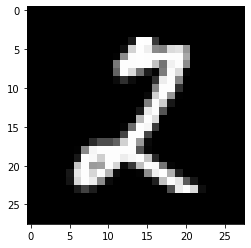

In [18]:
plt.imshow(y[0, 0].numpy())

In [62]:
# source_dual_net = nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(28 * 28, 1024),
#     nn.ReLU(),
#     nn.BatchNorm1d(1024),
#     nn.Linear(1024, 1024),
#     nn.ReLU(),
#     nn.BatchNorm1d(1024),
#     nn.Linear(1024, 1),
#     nn.Flatten(start_dim=0)
# )

# target_dual_net = nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(28 * 28, 1024),
#     nn.ReLU(),
#     nn.BatchNorm1d(1024),
#     nn.Linear(1024, 1024),
#     nn.ReLU(),
#     nn.BatchNorm1d(1024),
#     nn.Linear(1024, 1),
#     nn.Flatten(start_dim=0)
# )

# target_dual_net = Vector(initial=1e-2 * torch.randn(len(mnist)))

source_to_target_net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 28 * 28),
    Unflatten(28, 28),
    nn.Tanh()
)

In [63]:
# ot = torch.load('saved_models/generative_model.pth')
ot = NeuralOT(source_dual_net, target_dual_net, source_to_target_net, 
              regularization_mode='l2', regularization_parameter=0.05, 
              from_discrete=False, to_discrete=False).to(DEVICE)

In [40]:
plan_optimizer = Adam(ot.parameters(), lr=1e-3)
plan_scheduler = MultiStepLR(plan_optimizer, [20, 75])

In [43]:
losses = train(ot.plan_criterion, plan_optimizer, batch_generator, n_epochs=300, device=DEVICE, 
               scheduler=plan_scheduler)

100%|██████████| 300/300 [06:17<00:00,  1.27s/it]


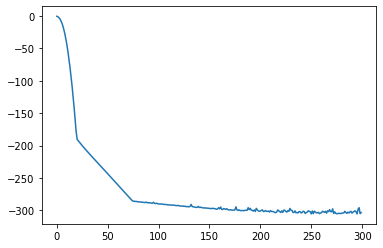

In [44]:
plt.plot(losses)

In [64]:
mapping_optimizer = Adam(ot.parameters(), lr=1e-4)
mapping_scheduler = None # MultiStepLR(plan_optimizer, [10])

In [65]:
mapping_losses = train(ot.mapping_criterion, mapping_optimizer, batch_generator, n_epochs=300, device=DEVICE, 
                       scheduler=mapping_scheduler)

100%|██████████| 300/300 [07:05<00:00,  1.43s/it]


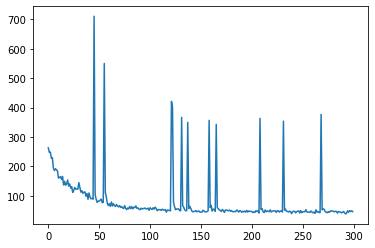

In [66]:
plt.plot(mapping_losses)

In [67]:
_, x = next(gaussian_sampler(MNIST_MEAN, MNIST_COV, batch_size=100, n_batches=1))
x = x.to(DEVICE)
mapped = ot.map(x)
imgs = mapped[:, 0].detach().cpu().numpy()

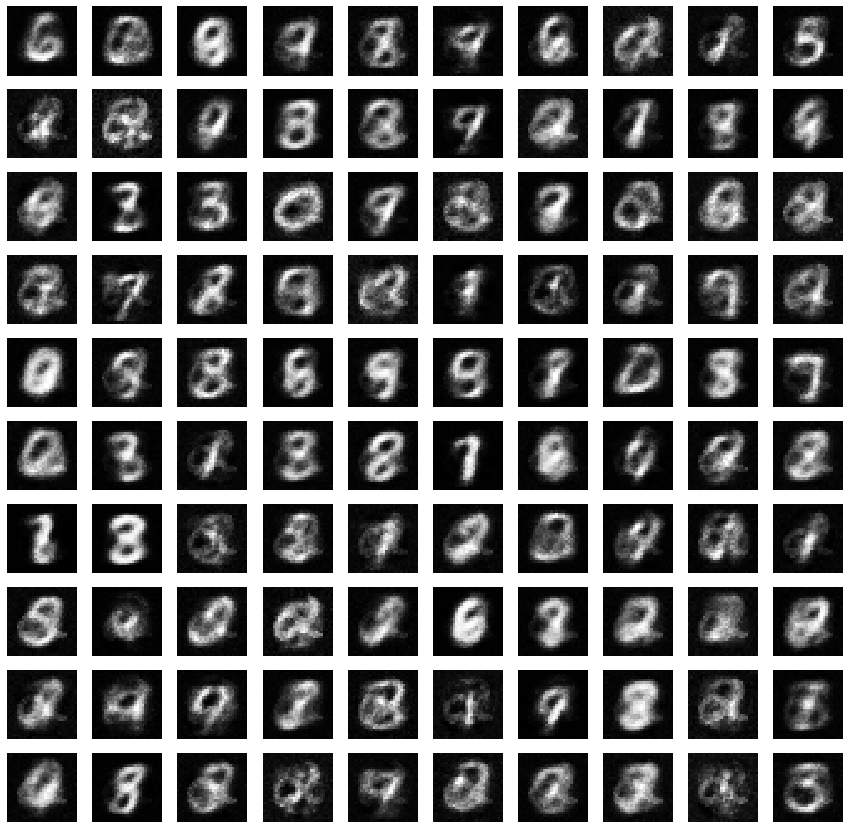

In [68]:
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(15, 15))
for i, img in enumerate(imgs):
    ax = axes[i // 10, i % 10]
    ax.imshow(img)
    ax.axis('off')

In [385]:
torch.save(ot, '../generative_model.pth')